In [1]:
from PIL import Image
import numpy as np
import cv2

In [2]:
patch_location = [200,310]
patch_shape = [3,100,100]

In [15]:
img = Image.open(
    'D:\\NewPatchGen\\Assets\\Random_noise_100.jpeg')
img = img.rotate(180)

# add red background
red_img = np.full((640, 640, 3), (0, 0, 255),
                    dtype=np.uint8)
x_center = (640 - img.size[1]) // 2
y_center = (640 - img.size[0]) // 2
red_img[y_center:y_center + img.size[1],
        x_center:x_center + img.size[0]] = img
red_img_reshape = red_img.transpose((2, 0, 1))
red_image = np.stack([red_img_reshape], axis=0).astype(np.float32)

# get contours and change all values outside of the contour to noise
red_img_array = np.array(red_img)
gray = cv2.cvtColor(np.array(red_img_array), cv2.COLOR_RGB2GRAY)
edged = cv2.Canny(gray, 30, 200)
contours, hierarchy = cv2.findContours(
    edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
rect_x, rect_y, rect_w, rect_h = cv2.boundingRect(contours[1])

# create mask
mask = np.zeros_like(red_img_array)
cv2.drawContours(mask, contours, 2, (255, 255, 255), -1)
mask = mask[:, :, 0]

# create 640x640 noise
noise = np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8)
fg = cv2.bitwise_or(red_img_array, red_img_array, mask=mask)
mask = cv2.bitwise_not(mask)
bk = cv2.bitwise_or(noise, noise, mask=mask)
final = cv2.bitwise_or(fg, bk)
# cv2.imwrite('Patch/noisy.jpeg', cv2.cvtColor(final, cv2.COLOR_RGB2BGR))

# final_reshape = final.transpose((2, 0, 1))
# image = np.stack([final_reshape], axis=0).astype(np.float32)
# image = image / 255.0
# x = image.copy()

YOLOv5  2023-12-7 Python-3.9.18 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)

Fusing layers... 
YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs
Adding AutoShape... 


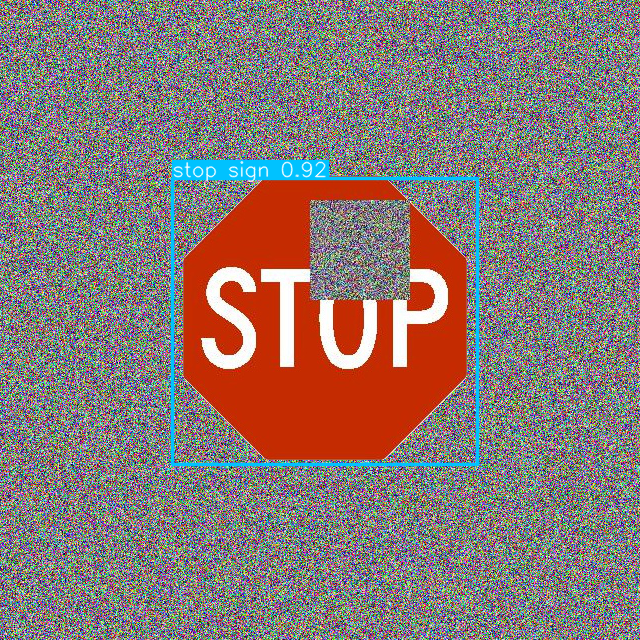

In [16]:
import yolov5
model = yolov5.load('Assets/yolov5s.pt')

results = model(final)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

# show detection bounding boxes on image
results.show()

In [4]:
patch_img = Image.open('C:\\Users\\Devon\\Project\\NewPatchGen\\outputs\\2023-09-19\\22-26-38\\Patch\\patch.png')
x_1, y_1 = patch_location
x_2, y_2 = x_1 + patch_shape[1], y_1 + patch_shape[2]

red_img[x_1:x_2, y_1:y_2] = patch_img

crop = red_img[rect_y:rect_y + rect_h, rect_x:rect_x + rect_w]
texture = Image.fromarray(crop.astype(np.uint8))
texture = texture.rotate(180)
texture.save('C:\\Users\\Devon\\Project\\NewPatchGen\\outputs\\2023-09-19\\22-26-38\\Patch\\texture.png')
